In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [ ]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv
deaths = pd.read_csv('data/time_series_covid19_deaths.csv') #https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv 


<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [ ]:
cases = cases.fillna(0)
vaccinations = vaccinations.fillna(0)

In [ ]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [ ]:
fips_lst = []
code = 0
for i in range(len(counties)):
    if counties.iloc[i, :]['CTYNAME'] == counties.iloc[i, :]['STNAME'] and counties.iloc[i, :]['CTYNAME'] in counties['STNAME']:
        code = float(counties.iloc[i, :]['STATE'])
        fips_lst.append(int(code))
        code = 0
    else:
        code += 1000 * counties.iloc[i, :]['STATE'] + counties.iloc[i, :]['COUNTY']
        fips_lst.append(int(code))
        code = 0
counties['FIPS'] = fips_lst

In [ ]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [ ]:
mask_copy = mask_use.copy()
mask_copy = mask_copy.rename(columns = {'COUNTYFP': 'FIPS'})
df_concat = [counties, cases, mask_copy]
df_concat = [df.set_index('FIPS') for df in df_concat]
df_concat = df_concat[0].join(df_concat[1:], how = 'inner').fillna(0)
county_data = df_concat.reset_index()
county_data['COUNTYFP'] = [mask_use['COUNTYFP'][i] for i in range(len(county_data) + 1) if mask_use['COUNTYFP'][i] in list(county_data['FIPS'])]


In [ ]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

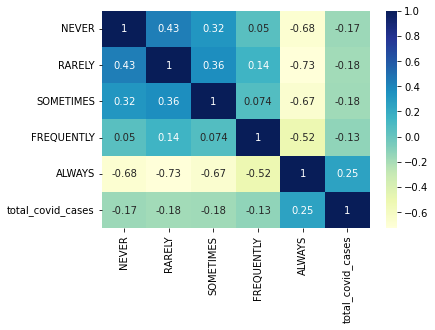

In [ ]:
df_5a = county_data.loc[:, ['NEVER', 'RARELY','SOMETIMES','FREQUENTLY', 'ALWAYS']]
df_5a['total_covid_cases'] = county_data.loc[:, '1/22/20':'9/12/21'].sum(axis=1)
dataplot = sns.heatmap(df_5a.corr(), cmap="YlGnBu", annot=True)

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [ ]:
dfsep12 = county_data[['COUNTYFP', 'NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS','9/12/21','POPESTIMATE2020']]
X_q5b = dfsep12[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]
y_q5b = dfsep12['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test =  train_test_split(X_q5b, y_q5b, test_size = .33, random_state = 42)

import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

linear_model.fit(X_q5b_train, y_q5b_train)

Y_pred = linear_model.predict(X_q5b_test)

def rmse(actual_y, predicted_y):
    error = actual_y - predicted_y
    sq_error = error ** 2
    mean = np.mean(sq_error)
    return np.sqrt(mean)

train_rmse_cases, test_rmse_cases =  rmse(y_q5b_train, linear_model.predict(X_q5b_train)), rmse(y_q5b_test, linear_model.predict(X_q5b_test))
train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [ ]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

The reason the test set RMSE is much higher compared to the training set RMSE is because there is potential "overfitting" of the data, such that we're introducing too many features into the complexity of our model. Another potential reason is that we might not have enough training dataset compared to the testing dataset. 

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [ ]:
X_q5d = dfsep12[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]
y_q5d = dfsep12['9/12/21'].divide(dfsep12['POPESTIMATE2020'], axis = 0)

X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size = .33, random_state = 42)


linear_model = lm.LinearRegression()

linear_model.fit(X_q5d_train, y_q5d_train)

Y_pred_5d = linear_model.predict(X_q5d_test)


train_rmse_cpc, test_rmse_cpc = rmse(y_q5d_train, linear_model.predict(X_q5d_train)), rmse(y_q5d_test, linear_model.predict(X_q5d_test))

# The training and testing rmse were pretty similar when we were predicting the number of cases per capita instead of the total number of cases

In [ ]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

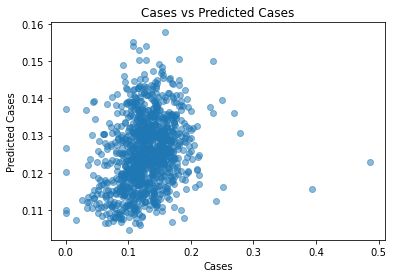

In [ ]:
plt.scatter(y_q5d_test, Y_pred_5d, alpha=0.5)
plt.xlabel("Cases")
plt.ylabel("Predicted Cases")
plt.title("Cases vs Predicted Cases");

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [ ]:
models = []
for i in np.arange(1000):
    sample_X_q5d_train = X_q5d_train.sample(frac = 1, replace = True)
    sample_y_q5d_train = y_q5d_train.sample(frac = 1, replace = True)
    linear_model = lm.LinearRegression()
    models.append(linear_model.fit(sample_X_q5d_train, sample_y_q5d_train))

In [ ]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [ ]:
predictions = []

for i in np.arange(len(models)):
    pred = models[i].predict(X_q5d_test.iloc[[100]])[0]
    predictions.append(pred)

prop_var = np.var(predictions) / np.mean((y_q5d_test.iloc[100] - predictions) ** 2)
prop_var

0.0010167264382743234

In [ ]:
# variance of predictions
np.var(predictions)

2.523471947686405e-06

In [ ]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

i.) We start with the model risk equation, such as:
   $$modelrisk = bias^2 + model variance + random noise $$
In this case, since random noise is equal to zero, we only have bias and the model variance to work with. Based on 5g, the variance is also equal to about zero, since it's  2.68e-06. Finally, to calculate the bias, we will square the difference between the predicted value and our true values. To calculate, we use the code: `np.mean((y_q5d_test.iloc[100] - predictions) ** 2)` to get exactly 0.002. Altogether, the model risk will equate to zero and that the magnitude will have zero effect on the sample point.


ii.) The issue with 5h(i) assumptions is that its impossible for the model to have zero noise because even with a good model, data will always have a certain amount of irreducible error. Especially with the generation of COVID-19 case data being "highly non-random," the results of 5h(i) do not provide a good comprehension on the true population because as mentioned in 5h(i), the model risk only contains a single sample point. Likewise, the number of covid cases does not account for testing patterns, let alone having a low correlation between the number of covid cases per capita and the frequency of mask usage.

iii.) In the practical setting, $\epsilon$ or noise error ideally should have a mean equal to 0, because the sum of the residuals of the error term also equals to 0. Likewise, the standard deviation being greater than 0, or in this case, the mean is normal because it shows how distributed it is across the mean. I wouldn't say that there are any immediate issues with the assumption that the mean of the error term is equal to 0, and its standard deviation being greater than 0. In fact, the assumptions should stay because with a mean greater or less than 0, our model would always 
either overpredict or underpredict our true values. As such, the conditions on $\mu$ and $\sigma$ should stay the same, with $\mu = 0$ and $\sigma  > 0$.

iv.) The bias-variance decomposition presented in lecture does hold because the model risk comes out to equal to 0, with $\epsilon$, variance, and bias all being equal to 0 with the sample point. For example, the sample point the 100th sample point is 0.176, and $\epsilon$ equals to 0. If we were to add or subtract from the `y` value, then we would have a greater difference with our prediction of the true sample in our model.

v.) Intuitively, it would be impossible to reduce bias to zero because any data you collect will always have bias regardless. Likewise, the article claims that the COVID dataset is "non-random", which would make it not possible to minimize bias to zero. With a non-random dataset, there would be a higher amount of irreducible noise within the data, giving a higher error term in the model risk. This would overall invalidate the bias-variance decomposition of the model, with the magnitude of bias on sample points higher than zero.

vi.) With an infinite sample case, it's possible to reduce bias to zero because if we can consider all possible scenarios of bias within the data collected, then we would be able to take into account all these factors that lead to bias, and ultimately reduce the bias to zero. However, in reality, it is unlikely to attain all the resources to replicate infinite samples.

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [ ]:
var = []
mse = []
for i in np.arange(len(models)):
    pred = models[i].predict(X_q5d_test)
    var.append(np.var(pred))
    mse.append(rmse(y_q5d_test, pred) ** 2)

avg_var, avg_mse = np.mean(var), np.mean(mse)

avg_var, avg_mse

(2.9540357171504672e-06, 0.0015615848610438482)

In [ ]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

To reduce the mean square error, we would first make sure that the data we're training and testing is clean, so that we can reduce as much random noise as possible in the dataset. Also, we would need to find a balance between the complexity of our model, because too much will cause high variance, while too little will cause high bias in the model risk. In the meantime, we can also collect more recent data on the COVID data set in order to reduce the overall variance and bias of our model.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [ ]:
import calendar
# 6a dataframe
deaths_6a = deaths.copy()
deaths_6a = deaths.loc[:, :'9/12/21']
drop_col = ['Admin2','Country_Region','Lat','Long_','Combined_Key','Population','UID','iso2','iso3','code3']
deaths_6a = deaths_6a.drop(drop_col, axis = 1)
lst_6a = np.array(deaths_6a["FIPS"])
deaths_6a['FIPS'] = lst_6a.astype(int)
county_data_6a = county_data.copy()
county_data_6a = county_data_6a.loc[:, :'1/22/20'].iloc[:, :-1]
df_deaths_6a = county_data_6a.merge(deaths_6a)

y = vaccinations[vaccinations['Date'] == '2021-09-12']
x = df_deaths_6a.groupby("STNAME").agg(sum)
y = y[y['Province_State'].isin(x.index)].set_index('Province_State')
z = x.merge(y, left_index=True, right_index=True, how='inner')
deaths_vaccinations = z.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE',"ESTIMATESBASE2010",  'COUNTY','POPESTIMATE2010', "POPESTIMATE042020", 'POPESTIMATE2011', 'POPESTIMATE2012', "POPESTIMATE2013", "POPESTIMATE2014", "POPESTIMATE2015", "POPESTIMATE2016", "POPESTIMATE2017","POPESTIMATE2018","POPESTIMATE2019", "UID", "code3", "Lat_x", "Long__x", "Lat_y", "Long__y", "FIPS_y", "Country_Region", "Combined_Key"], axis = 1)
dvdf = deaths_vaccinations.loc[:, '1/22/20':'9/12/21']
dvdf.columns = pd.to_datetime(dvdf.columns)

lst = []
lst_2 = []
mm = 1
for i in dvdf.columns:
    if i.month == mm:
        lst.append(i)
    else:
        mm += 1
        lst_2.append(lst)
        lst = []
        if mm > 12:
            mm = 1
lst_2 = lst_2 + [lst]
lst_3 = []
for i in np.arange(21):
    lst_3.append(lst_2[i][-1])
dvdf = dvdf.loc[:, lst_3]
month_names = [calendar.month_name[i] for i in range(1,13)]
twenty20 = [month + " '20" for month in month_names]
twenty21 = [month + " '21" for month in month_names[:9]]
dvdf.columns = twenty20 + twenty21
dvdf = dvdf.divide(deaths_vaccinations['POPESTIMATE2020'], axis = 0)
dvdf = dvdf.diff(axis = 1)
dvdf['People_Fully_Vaccinated'] = deaths_vaccinations['People_Fully_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020']
dvdf['People_Partially_Vaccinated'] = deaths_vaccinations['People_Partially_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020']
dvdf['Population2020'] = deaths_vaccinations['POPESTIMATE2020']
dvdf = dvdf.fillna(value = 0)
dvdf.head()

,January '20,February '20,March '20,April '20,May '20,June '20,July '20,August '20,September '20,October '20,...,March '21,April '21,May '21,June '21,July '21,August '21,September '21,People_Fully_Vaccinated,People_Partially_Vaccinated,Population2020
STNAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.000003,0.000052,0.000073,0.000060,0.000123,0.000112,0.000093,0.000087,...,0.000127,0.000069,0.000051,0.000042,0.000037,0.000152,0.000080,0.400493,0.110336,4921532
Alaska,0.0,0.0,0.000001,0.000006,0.000007,0.000006,0.000012,0.000019,0.000026,0.000035,...,0.000032,0.000047,0.000030,0.000011,0.000017,0.000076,0.000019,0.496534,0.075520,721812
Arizona,0.0,0.0,0.000002,0.000041,0.000079,0.000100,0.000276,0.000180,0.000084,0.000044,...,0.000133,0.000048,0.000041,0.000042,0.000042,0.000073,0.000054,0.487078,0.081539,7421401
Arkansas,0.0,0.0,0.000002,0.000018,0.000024,0.000045,0.000060,0.000114,0.000189,0.000183,...,0.000126,0.000037,0.000031,0.000025,0.000077,0.000262,0.000110,0.435045,0.108019,3030522
California,0.0,0.0,0.000004,0.000046,0.000054,0.000047,0.000078,0.000094,0.000076,0.000048,...,0.000156,0.000065,0.000036,0.000026,0.000022,0.000038,0.000033,0.586602,0.130071,39368078


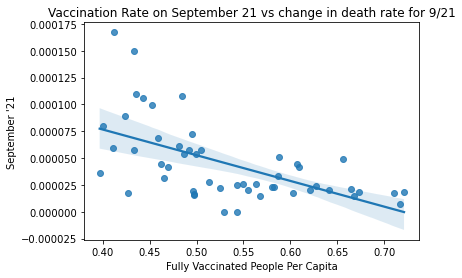

In [ ]:
eda = dvdf.rename(columns = {"People_Fully_Vaccinated": "Fully Vaccinated People Per Capita"})
eda
scat = sns.regplot(eda["Fully Vaccinated People Per Capita"], eda["September '21"]).set(title = "Vaccination Rate on September 21 vs change in death rate for 9/21")
scat;

#### Baseline Without Fully and Partially Vaccinated Features

In [ ]:
col = list(dvdf.columns[2:12])
X_basee = dvdf[col]
y_basee = dvdf[dvdf.columns[20]]

# Make sure to set random_state = 42 and test_size = 0.33!
X_train, X_test, y_train, y_test =  train_test_split(X_basee, y_basee, test_size = .33, random_state = 42)

import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

linear_model.fit(X_train, y_train)

Y_pred_6a = linear_model.predict(X_test)

train_rmse_cases6, test_rmse_cases6 =  rmse(y_train, linear_model.predict(X_train)), rmse(y_test, linear_model.predict(X_test))
train_rmse_cases6, test_rmse_cases6

(1.8498165999375868e-05, 6.840357745029349e-05)

#### Baseline With Fully and Partially Vaccinated Features

In [ ]:
col = list(dvdf.columns[2:12]) + ['People_Fully_Vaccinated', "People_Partially_Vaccinated"]
X_q6a = dvdf[col]
y_q6a = dvdf[dvdf.columns[20]]

# Make sure to set random_state = 42 and test_size = 0.33!
X_q6a_train, X_q6a_test, y_q6a_train, y_q6a_test =  train_test_split(X_q6a, y_q6a, test_size = .33, random_state = 42)

import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

linear_model.fit(X_q6a_train, y_q6a_train)

Y_pred_6a = linear_model.predict(X_q6a_test)

train_rmse_cases_6a, test_rmse_cases_6a =  rmse(y_q6a_train, linear_model.predict(X_q6a_train)), rmse(y_q6a_test, linear_model.predict(X_q6a_test))
train_rmse_cases_6a, test_rmse_cases_6a


(1.638483009443846e-05, 6.562563236544584e-05)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [ ]:
cols6b = list(dvdf.columns[12:20]) + ['People_Fully_Vaccinated', "People_Partially_Vaccinated"]
X_q6b = dvdf[cols6b]
y_q6b = dvdf[dvdf.columns[20]]

# Make sure to set random_state = 42 and test_size = 0.33!
X_q6b_train, X_q6b_test, y_q6b_train, y_q6b_test =  train_test_split(X_q6b, y_q6b, test_size = .33, random_state = 42)

import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

linear_model.fit(X_q6b_train, y_q6b_train)

Y_pred_6b = linear_model.predict(X_q6b_test)

train_rmse_cases_6b, test_rmse_cases_6b =  rmse(y_q6b_train, linear_model.predict(X_q6b_train)), rmse(y_q6b_test, linear_model.predict(X_q6b_test))
train_rmse_cases_6b, test_rmse_cases_6b


(1.2953704365009264e-05, 2.9977873507974467e-05)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

The prediction function with our linear regression will introduce a new variable $m$, where $m$ represents the days within a month and that $0 <$ $m$ $\leq 31$. The number of days and months $n$ is denoted on the available days and months from the current and exported dataset.

As such, 
$f(x) = x_{m + ... m + n} + x_{{m_2} + ... m + n} + ..., x_{{m_n} + m + n}$

where we will predict future monthly or daily deaths with our baseline and improved model. Both the baseline and improved model will contain the percentage of fully and partially vaccinated people. However, the optimal parameters for the improved model will contain monthly the death rates in year 2021, while the baseline will contain death rates in the year 2020. This is to compare whether the models will improve their prediction based on older data versus newer data.

two_days<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

## Baseline Model

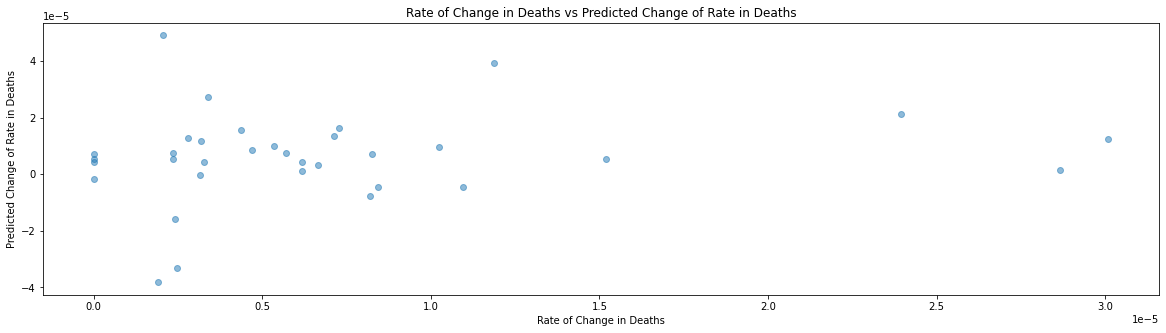

In [ ]:
# short-term baseline model
# predict a week
deaths_6d = deaths.copy()
deaths_6d = deaths_6d[deaths_6d['Province_State'].isin(dvdf.index)].groupby('Province_State').agg(sum)
two_days = deaths_6d.loc[:, '9/12/21':'9/14/21']
two_days = two_days.divide(deaths_vaccinations['POPESTIMATE2020'], axis = 0)
two_days = two_days.diff(axis = 1).drop(columns = '9/12/21')
two_days[two_days < 0] = 0


X_q6d_base = X_q6a
y_q6d_base = two_days

X_q6d_train_base, X_q6d_test_base, y_q6d_train_base, y_q6d_test_base =  train_test_split(X_q6d_base, y_q6d_base, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6d_train_base, y_q6d_train_base)

Y_pred_6d_base = linear_model.predict(X_q6d_test_base)

train_rmse_cases_6d_base, test_rmse_cases_6d_base = rmse(y_q6d_train_base, linear_model.predict(X_q6d_train_base)), rmse(y_q6d_test_base, linear_model.predict(X_q6d_test_base))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6d_test_base, Y_pred_6d_base, alpha=0.5);
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [ ]:
print("Train RMSE")
print(train_rmse_cases_6d_base.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6d_base.to_string())
print("Accuracy: " + str(linear_model.score(X_q6d_train_base, y_q6d_train_base)))

Train RMSE
9/13/21    0.000004
9/14/21    0.000006

Test RMSE
9/13/21    0.000013
9/14/21    0.000020
Accuracy: 0.6337354429959771


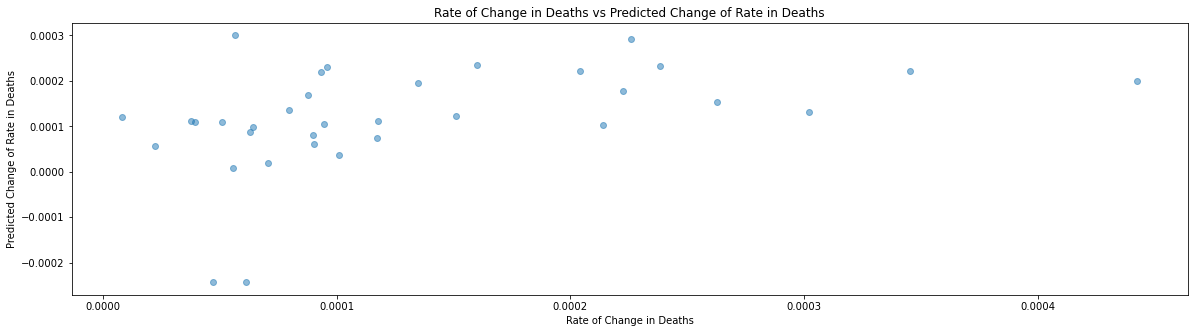

In [ ]:
# long-term baseline model
# predict a few months
few_months = deaths_6d.loc[:, '8/1/21':]
few_months.columns = pd.to_datetime(few_months.columns)
lst = []
lst_2 = []
mm = 1
for i in few_months.columns:
    if i.month == mm:
        lst.append(i)
    else:
        mm += 1
        lst_2.append(lst)
        lst = []
        if mm > 12:
            mm = 1
lst_2 = lst_2 + [lst]
lst_2 = [x for x in lst_2 if x != []]
lst_3 = []
for i in np.arange(5):
    lst_3.append(lst_2[i][-1])
lst_3
few_months = few_months.loc[:, lst_3]
few_months
few_months = few_months.divide(deaths_vaccinations['POPESTIMATE2020'], axis = 0)
few_months = few_months.diff(axis = 1).drop(columns = "2021-08-31 00:00:00")
twenty21_6d = [month + " '21" for month in month_names[8:]]
few_months.columns = twenty21_6d
few_months['Population2020'] = deaths_vaccinations['POPESTIMATE2020'] 
few_months['People_Fully_Vaccinated'] = deaths_vaccinations['People_Fully_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020'] 
few_months['People_Partially_Vaccinated'] = deaths_vaccinations['People_Partially_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020'] 

X_q6d_base_2 = X_q6a
y_q6d_base_2 = few_months.loc[:, ["October '21", "November '21"]]

X_q6d_train_base_2, X_q6d_test_base_2, y_q6d_train_base_2, y_q6d_test_base_2 =  train_test_split(X_q6d_base_2, y_q6d_base_2, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6d_train_base_2, y_q6d_train_base_2)

Y_pred_6d_base_2 = linear_model.predict(X_q6d_test_base_2)

train_rmse_cases_6d_base_2, test_rmse_cases_6d_base_2 = rmse(y_q6d_train_base_2, linear_model.predict(X_q6d_train_base_2)), rmse(y_q6d_test_base_2, linear_model.predict(X_q6d_test_base_2))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6d_test_base_2, Y_pred_6d_base_2, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");


In [ ]:
print("Train RMSE")
print(train_rmse_cases_6d_base_2.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6d_base_2.to_string())
print("Accuracy: " + str(linear_model.score(X_q6d_train_base_2, y_q6d_train_base_2)))

Train RMSE
October '21     0.000048
November '21    0.000044

Test RMSE
October '21     0.000108
November '21    0.000125
Accuracy: 0.6642123857363356


## Improved Model

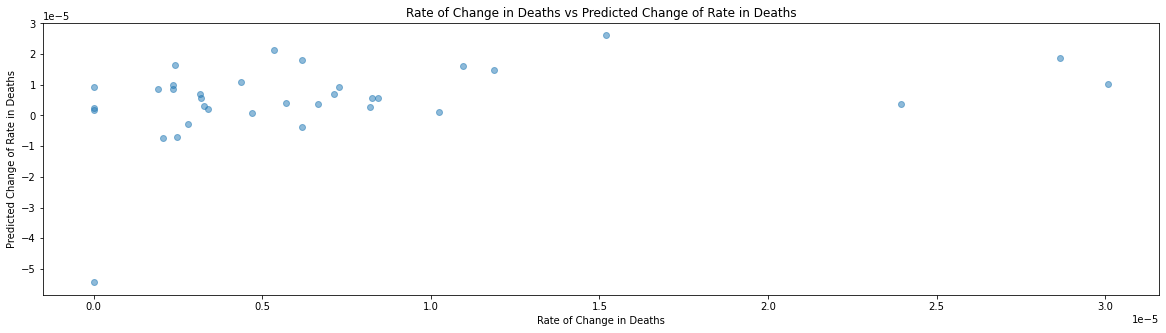

In [ ]:
# short-term improved model
# predict a week

X_q6d_improve = X_q6b
y_q6d_improve = two_days

X_q6d_train_improve, X_q6d_test_improve, y_q6d_train_improve, y_q6d_test_improve =  train_test_split(X_q6d_improve, y_q6d_improve, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6d_train_improve, y_q6d_train_improve)

Y_pred_6d_improve = linear_model.predict(X_q6d_test_improve)

train_rmse_cases_6d_improve, test_rmse_cases_6d_improve = rmse(y_q6d_train_improve, linear_model.predict(X_q6d_train_improve)), rmse(y_q6d_test_improve, linear_model.predict(X_q6d_test_improve))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6d_test_improve, Y_pred_6d_improve, alpha=0.5);
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [ ]:
print("Train RMSE")
print(train_rmse_cases_6d_improve.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6d_improve.to_string())
print("Accuracy: " + str(linear_model.score(X_q6d_train_improve, y_q6d_train_improve)))

Train RMSE
9/13/21    0.000005
9/14/21    0.000009

Test RMSE
9/13/21    0.000009
9/14/21    0.000015
Accuracy: 0.4061811685878902


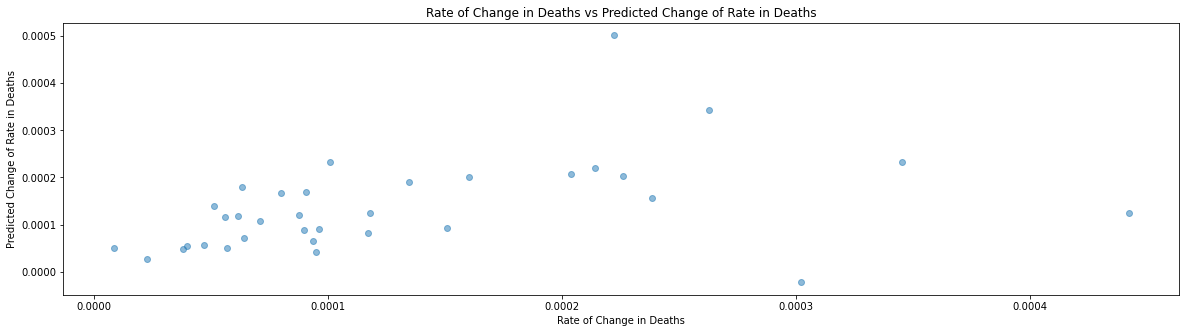

In [ ]:
# long-term improved model
# predict a few months
X_q6d_improve_2 = X_q6b
y_q6d_improve_2 = few_months.loc[:, ["October '21", "November '21"]]

X_q6d_train_improve_2, X_q6d_test_improve_2, y_q6d_train_improve_2, y_q6d_test_improve_2 =  train_test_split(X_q6d_improve_2, y_q6d_improve_2, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6d_train_improve_2, y_q6d_train_improve_2)

Y_pred_6d_improve_2 = linear_model.predict(X_q6d_test_improve_2)


train_rmse_cases_6d_improve_2, test_rmse_cases_6d_improve_2 = rmse(y_q6d_train_improve_2, linear_model.predict(X_q6d_train_improve_2)), rmse(y_q6d_test_improve_2, linear_model.predict(X_q6d_test_improve_2))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6d_test_improve_2, Y_pred_6d_improve_2, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [ ]:
print("Train RMSE")
print(train_rmse_cases_6d_improve_2.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6d_improve_2.to_string())
print("Accuracy: " + str(linear_model.score(X_q6d_train_improve_2, y_q6d_train_improve_2)))

Train RMSE
October '21     0.000049
November '21    0.000051

Test RMSE
October '21     0.000119
November '21    0.000094
Accuracy: 0.6122690517279052


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

## Baseline Model 6e

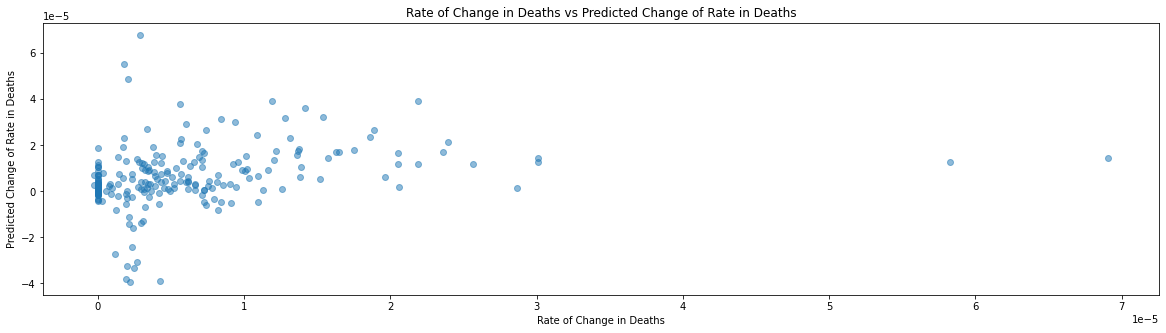

In [378]:
# short-term baseline model
# predict a week
deaths_6e = deaths.copy()
deaths_6e = deaths_6e[deaths_6e['Province_State'].isin(dvdf.index)].groupby('Province_State').agg(sum)
two_weeks_6e = deaths_6e.loc[:, '9/12/21':'9/26/21']
two_weeks_6e = two_weeks_6e.divide(deaths_vaccinations['POPESTIMATE2020'], axis = 0)
two_weeks_6e = two_weeks_6e.diff(axis = 1).drop(columns = '9/12/21')

X_q6e_base = X_q6a
y_q6e_base = two_weeks_6e

X_q6e_train_base, X_q6e_test_base, y_q6e_train_base, y_q6e_test_base =  train_test_split(X_q6e_base, y_q6e_base, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6e_train_base, y_q6e_train_base)

Y_pred_6e_base = linear_model.predict(X_q6e_test_base)

train_rmse_cases_6e_base, test_rmse_cases_6e_base = rmse(y_q6e_train_base, linear_model.predict(X_q6e_train_base)), rmse(y_q6e_test_base, linear_model.predict(X_q6e_test_base))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6e_test_base, Y_pred_6e_base, alpha=0.5);
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");


In [379]:
print("Train RMSE")
print(train_rmse_cases_6e_base.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6e_base.to_string())
print("Accuracy: " + str(linear_model.score(X_q6e_train_base, y_q6e_train_base)))

Train RMSE
9/13/21    0.000004
9/14/21    0.000006
9/15/21    0.000005
9/16/21    0.000008
9/17/21    0.000007
9/18/21    0.000005
9/19/21    0.000002
9/20/21    0.000005
9/21/21    0.000008
9/22/21    0.000008
9/23/21    0.000006
9/24/21    0.000010
9/25/21    0.000004
9/26/21    0.000002

Test RMSE
9/13/21    0.000013
9/14/21    0.000020
9/15/21    0.000020
9/16/21    0.000015
9/17/21    0.000007
9/18/21    0.000005
9/19/21    0.000002
9/20/21    0.000011
9/21/21    0.000024
9/22/21    0.000015
9/23/21    0.000016
9/24/21    0.000008
9/25/21    0.000006
9/26/21    0.000002
Accuracy: 0.48359609201991355


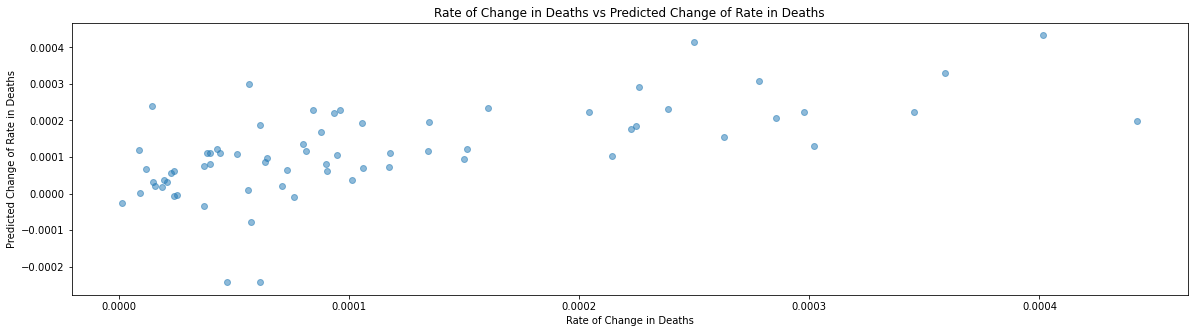

In [380]:
# long-term baseline model
# predict a few months

X_q6e_base_2 = X_q6a
y_q6e_base_2 = few_months.loc[:, :"December '21"]

X_q6e_train_base_2, X_q6e_test_base_2, y_q6e_train_base_2, y_q6e_test_base_2 =  train_test_split(X_q6e_base_2, y_q6e_base_2, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6e_train_base_2, y_q6e_train_base_2)

Y_pred_6e_base_2 = linear_model.predict(X_q6e_test_base_2)

train_rmse_cases_6e_base_2, test_rmse_cases_6e_base_2 = rmse(y_q6e_train_base_2, linear_model.predict(X_q6e_train_base_2)), rmse(y_q6e_test_base_2, linear_model.predict(X_q6e_test_base_2))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6e_test_base_2, Y_pred_6e_base_2, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [381]:
print("Train RMSE")
print(train_rmse_cases_6e_base_2.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6e_base_2.to_string())
print("Accuracy: " + str(linear_model.score(X_q6e_train_base_2, y_q6e_train_base_2)))

Train RMSE
September '21    0.000056
October '21      0.000048
November '21     0.000044
December '21     0.000058

Test RMSE
September '21    0.000084
October '21      0.000108
November '21     0.000125
December '21     0.000068
Accuracy: 0.5932735195226945


## Improved Model 6e

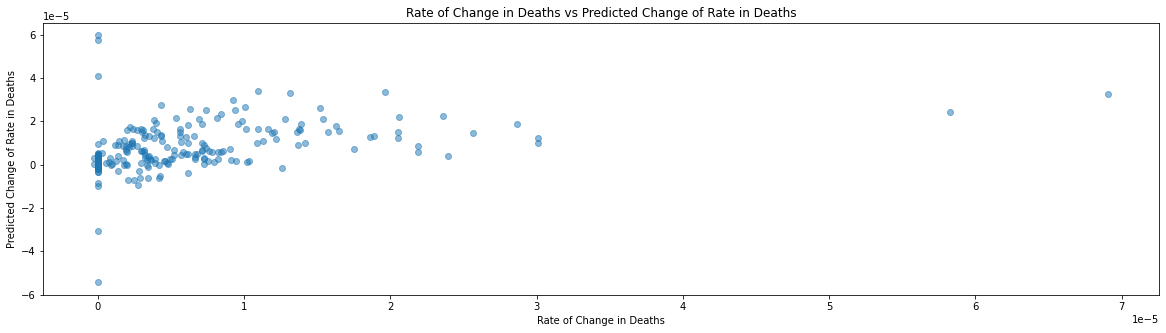

In [382]:
# short-term baseline model
# predict a week

X_q6e_improve = X_q6b
y_q6e_improve = two_weeks_6e

X_q6e_train_improve, X_q6e_test_improve, y_q6e_train_improve, y_q6e_test_improve =  train_test_split(X_q6e_improve, y_q6e_improve, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6e_train_improve, y_q6e_train_improve)

Y_pred_6e_improve = linear_model.predict(X_q6e_test_improve)

train_rmse_cases_6e_improve, test_rmse_cases_6e_improve = rmse(y_q6e_train_improve, linear_model.predict(X_q6e_train_improve)), rmse(y_q6e_test_improve, linear_model.predict(X_q6e_test_improve))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6e_test_improve, Y_pred_6e_improve, alpha=0.5);
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [383]:
print("Train RMSE")
print(train_rmse_cases_6e_improve.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6e_improve.to_string())
print("Accuracy: " + str(linear_model.score(X_q6e_train_improve, y_q6e_train_improve)))

Train RMSE
9/13/21    0.000005
9/14/21    0.000009
9/15/21    0.000005
9/16/21    0.000009
9/17/21    0.000006
9/18/21    0.000005
9/19/21    0.000002
9/20/21    0.000006
9/21/21    0.000010
9/22/21    0.000007
9/23/21    0.000007
9/24/21    0.000010
9/25/21    0.000004
9/26/21    0.000002

Test RMSE
9/13/21    0.000009
9/14/21    0.000015
9/15/21    0.000014
9/16/21    0.000019
9/17/21    0.000007
9/18/21    0.000005
9/19/21    0.000002
9/20/21    0.000007
9/21/21    0.000011
9/22/21    0.000011
9/23/21    0.000017
9/24/21    0.000012
9/25/21    0.000004
9/26/21    0.000002
Accuracy: 0.41891320630567835


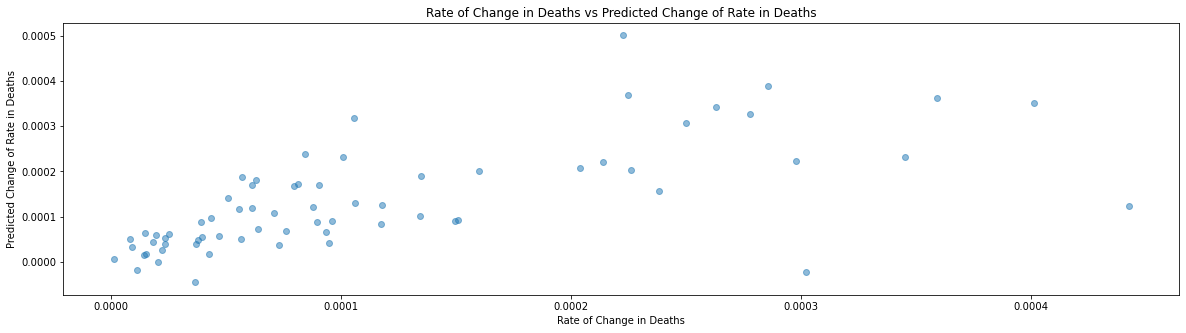

In [403]:
# long-term improved model
X_q6e_improve_2 = X_q6b
# y_q6e_improve_2 = few_months.loc[:, :"December '21"]

X_q6e_train_improve_2, X_q6e_test_improve_2, y_q6e_train_improve_2, y_q6e_test_improve_2 =  train_test_split(X_q6e_improve_2, y_q6e_improve_2, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6e_train_improve_2, y_q6e_train_improve_2)

Y_pred_6e_improve_2 = linear_model.predict(X_q6e_test_improve_2)

train_rmse_cases_6e_improve_2, test_rmse_cases_6e_improve_2 = rmse(y_q6e_train_improve_2, linear_model.predict(X_q6e_train_improve_2)), rmse(y_q6e_test_improve_2, linear_model.predict(X_q6e_test_improve_2))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6e_test_improve_2, Y_pred_6e_improve_2, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [404]:
print("Train RMSE")
print(train_rmse_cases_6e_improve_2.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6e_improve_2.to_string())
print("Accuracy: " + str(linear_model.score(X_q6e_train_improve_2, y_q6e_train_improve_2)))

Train RMSE
September '21    0.000063
October '21      0.000049
November '21     0.000051
December '21     0.000063

Test RMSE
September '21    0.000097
October '21      0.000119
November '21     0.000094
December '21     0.000035
Accuracy: 0.5216472531439558


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

# Model With 30 Days


In [405]:
# 30 day features
df_6f = deaths_6d.loc[:, '8/11/21':]
df_6f = df_6f.divide(deaths_vaccinations['POPESTIMATE2020'], axis = 0)
df_6f = df_6f.diff(axis = 1).drop(columns = '8/11/21')
df_6f['People_Fully_Vaccinated'] = deaths_vaccinations['People_Fully_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020'] 
df_6f['People_Partially_Vaccinated'] = deaths_vaccinations['People_Partially_Vaccinated'] / deaths_vaccinations['POPESTIMATE2020'] 
df_6f

X_q6f = df_6f.loc[:, '8/12/21':'9/10/21']
y_q6f = df_6f['9/11/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q6f_train, X_q6f_test, y_q6f_train, y_q6f_test =  train_test_split(X_q6f, y_q6f, test_size = .33, random_state = 42)

# import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

linear_model.fit(X_q6f_train, y_q6f_train)

Y_pred_6f = linear_model.predict(X_q6f_test)

train_rmse_cases_6f, test_rmse_cases_6f =  rmse(y_q6f_train, linear_model.predict(X_q6f_train)), rmse(y_q6f_test, linear_model.predict(X_q6f_test))
train_rmse_cases_6f, test_rmse_cases_6f

(3.796195910327839e-07, 7.5208658094055e-06)

The 30 day feature has a lower train and test RMSE than the baseline and improved model. We have improved the model again 
and will predict future days with just one month worth of previous data from October 12, 2021 to September 10, 2021.

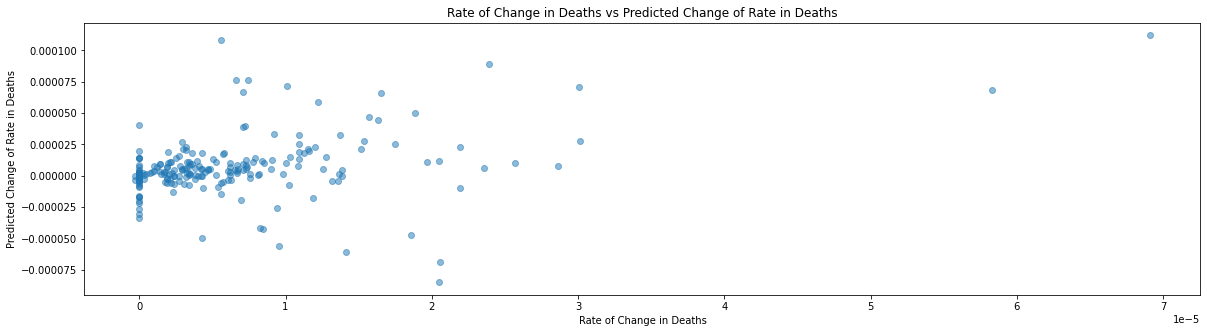

In [406]:
# short-term 30 days model
X_q6f_improve = df_6f.loc[:, '8/12/21':'9/10/21']
two_weeks_6f = df_6f.loc[:, '9/11/21':'9/24/21']
y_q6f_improve = two_weeks_6f

X_q6f_train_improve, X_q6f_test_improve, y_q6f_train_improve, y_q6f_test_improve =  train_test_split(X_q6f_improve, y_q6f_improve, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6f_train_improve, y_q6f_train_improve)

Y_pred_6f_improve = linear_model.predict(X_q6f_test_improve)

train_rmse_cases_6f_improve, test_rmse_cases_6f_improve =  rmse(y_q6f_train_improve, linear_model.predict(X_q6f_train_improve)), rmse(y_q6f_test_improve, linear_model.predict(X_q6f_test_improve))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6f_test_improve, Y_pred_6f_improve, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [407]:
print("Train RMSE")
print(train_rmse_cases_6f_improve.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6f_improve.to_string())
print("Accuracy: " + str(linear_model.score(X_q6f_train_improve, y_q6f_train_improve)))

Train RMSE
9/11/21    3.796196e-07
9/12/21    9.068398e-08
9/13/21    4.725364e-07
9/14/21    5.689251e-07
9/15/21    7.402878e-07
9/16/21    2.010958e-07
9/17/21    6.707108e-07
9/18/21    1.969415e-07
9/19/21    1.759948e-07
9/20/21    6.988045e-07
9/21/21    5.715877e-07
9/22/21    1.266204e-06
9/23/21    1.343199e-06
9/24/21    1.292419e-06

Test RMSE
9/11/21    0.000008
9/12/21    0.000003
9/13/21    0.000020
9/14/21    0.000017
9/15/21    0.000009
9/16/21    0.000013
9/17/21    0.000016
9/18/21    0.000014
9/19/21    0.000007
9/20/21    0.000017
9/21/21    0.000046
9/22/21    0.000028
9/23/21    0.000029
9/24/21    0.000029
Accuracy: 0.9920724458701972


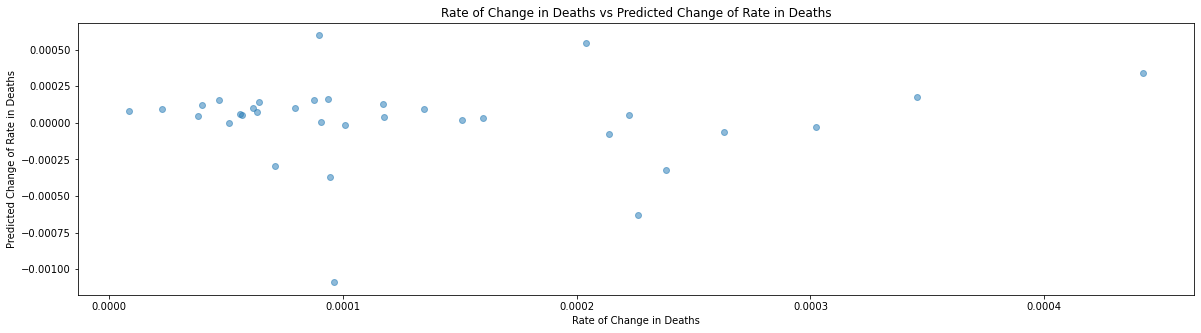

In [408]:
# long-term 30 days model
X_q6f_improve_2 = X_q6f_improve
# predict 2 months
y_q6f_improve_2 = few_months.loc[:, ["October '21", "November '21"]]

X_q6f_train_improve_2, X_q6f_test_improve_2, y_q6f_train_improve_2, y_q6f_test_improve_2 =  train_test_split(X_q6f_improve_2, y_q6f_improve_2, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6f_train_improve_2, y_q6f_train_improve_2)

Y_pred_6f_improve_2 = linear_model.predict(X_q6f_test_improve_2)

train_rmse_cases_6f_improve_2, test_rmse_cases_6f_improve_2 =  rmse(y_q6f_train_improve_2, linear_model.predict(X_q6f_train_improve_2)), rmse(y_q6f_test_improve_2, linear_model.predict(X_q6f_test_improve_2))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6f_test_improve_2, Y_pred_6f_improve_2, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [409]:
print("Train RMSE")
print(train_rmse_cases_6f_improve_2.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6f_improve_2.to_string())
print("Accuracy: " + str(linear_model.score(X_q6f_train_improve_2, y_q6f_train_improve_2)))

Train RMSE
October '21     0.000015
November '21    0.000017

Test RMSE
October '21     0.000273
November '21    0.000375
Accuracy: 0.9591627712052724


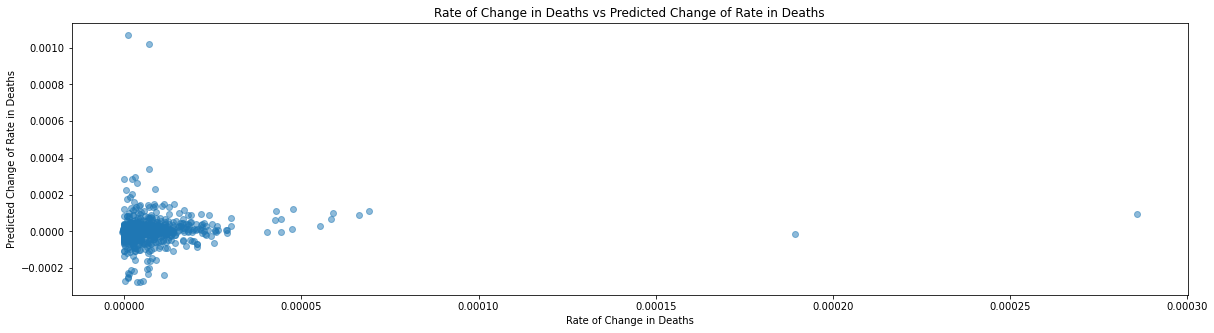

In [433]:
# Finally, lets see how accurate our new model can predict the rate of deaths
# long-term 30 days model
X_q6f_improve_3 = X_q6f_improve
# predict days up to latest deaths
y_q6f_improve_3 = df_6f.loc[:, "9/11/21":"12/8/21"]
X_q6f_train_improve_3, X_q6f_test_improve_3, y_q6f_train_improve_3, y_q6f_test_improve_3 =  train_test_split(X_q6f_improve_3, y_q6f_improve_3, test_size = .33, random_state = 42)

linear_model = lm.LinearRegression()

linear_model.fit(X_q6f_train_improve_3, y_q6f_train_improve_3)

Y_pred_6f_improve_3 = linear_model.predict(X_q6f_test_improve_3)

train_rmse_cases_6f_improve_3, test_rmse_cases_6f_improve_3 =  rmse(y_q6f_train_improve_3, linear_model.predict(X_q6f_train_improve_3)), rmse(y_q6f_test_improve_3, linear_model.predict(X_q6f_test_improve_3))
f, ax = plt.subplots(figsize=(20,5))
plt.scatter(y_q6f_test_improve_3, Y_pred_6f_improve_3, alpha=0.5)
plt.xlabel("Rate of Change in Deaths")
plt.ylabel("Predicted Change of Rate in Deaths")
plt.title("Rate of Change in Deaths vs Predicted Change of Rate in Deaths");

In [411]:
print("Train RMSE")
print(train_rmse_cases_6f_improve_3.to_string())
print()
print("Test RMSE")
print(test_rmse_cases_6f_improve_3.to_string())
print("Accuracy: " + str(linear_model.score(X_q6f_train_improve_3, y_q6f_train_improve_3)))

Train RMSE
9/11/21     3.796196e-07
9/12/21     9.068398e-08
9/13/21     4.725364e-07
9/14/21     5.689251e-07
9/15/21     7.402878e-07
9/16/21     2.010958e-07
9/17/21     6.707108e-07
9/18/21     1.969415e-07
9/19/21     1.759948e-07
9/20/21     6.988045e-07
9/21/21     5.715877e-07
9/22/21     1.266204e-06
9/23/21     1.343199e-06
9/24/21     1.292419e-06
9/25/21     7.138893e-07
9/26/21     3.601277e-07
9/27/21     1.363445e-06
9/28/21     9.803167e-06
9/29/21     1.588067e-06
9/30/21     5.365695e-07
10/1/21     3.691471e-07
10/2/21     8.710209e-07
10/3/21     1.298875e-07
10/4/21     1.096848e-06
10/5/21     7.123247e-07
10/6/21     2.484674e-06
10/7/21     6.190780e-07
10/8/21     1.169369e-06
10/9/21     6.015065e-07
10/10/21    6.176157e-08
10/11/21    1.162615e-06
10/12/21    9.685511e-07
10/13/21    2.173559e-06
10/14/21    5.858166e-07
10/15/21    1.782768e-06
10/16/21    6.194479e-07
10/17/21    1.876990e-07
10/18/21    1.818198e-06
10/19/21    2.007063e-06
10/20/21    1.

# Overview Comparison of RMSE and Model Peformances

#### 6a Model Train and Test RMSE - Base
(1.638483009443846e-05, 6.562563236544584e-05)

#### 6b Model Train and Test RMSE - Improve
(1.2953704365009264e-05, 2.9977873507974467e-05)

#### 6f Model Train and Test Rmse - Improve 2
(3.796195910327839e-07, 7.5208658094055e-06)

### 6d base short
Train RMSE\
9/13/21    0.000004\
9/14/21    0.000006

Test RMSE\
9/13/21    0.000013\
9/14/21    0.000020\
Accuracy: `0.6337354429959771`

### 6d base long
Train RMSE\
November '21    0.000044\
December '21    0.000058

Test RMSE\
November '21    0.000125\
December '21    0.000068\
Accuracy: `0.4869025631877755`

### 6d short improve 
Train RMSE\
9/13/21    0.000005\
9/14/21    0.000009

Test RMSE\
9/13/21    0.000009\
9/14/21    0.000015\
Accuracy: `0.4061811685878902`

### 6d long improve 
Train RMSE\
November '21    0.000051\
December '21    0.000063

Test RMSE\
November '21    0.000094\
December '21    0.000035\
Accuracy: `0.3832385180135171`

### 6e short base
Train RMSE\
9/13/21    0.000004\
9/14/21    0.000006\
9/15/21    0.000005\
9/16/21    0.000008\
9/17/21    0.000007\
9/18/21    0.000005\
9/19/21    0.000002\
9/20/21    0.000005\
9/21/21    0.000008\
9/22/21    0.000008\
9/23/21    0.000006\
9/24/21    0.000010\
9/25/21    0.000004\
9/26/21    0.000002

Test RMSE\
9/13/21    0.000013\
9/14/21    0.000020\
9/15/21    0.000020\
9/16/21    0.000015\
9/17/21    0.000007\
9/18/21    0.000005\
9/19/21    0.000002\
9/20/21    0.000011\
9/21/21    0.000024\
9/22/21    0.000015\
9/23/21    0.000016\
9/24/21    0.000008\
9/25/21    0.000006\
9/26/21    0.000002\
Accuracy: `0.48359609201991355`

### 6e long base
Train RMSE\
September '21    0.000056\
October '21      0.000048\
November '21     0.000044\
December '21     0.000058

Test RMSE\
September '21    0.000084\
October '21      0.000108\
November '21     0.000125\
December '21     0.000068\
Accuracy: `0.5932735195226945`

### 6e short improve
Train RMSE\
9/13/21    0.000005\
9/14/21    0.000009\
9/15/21    0.000005\
9/16/21    0.000009\
9/17/21    0.000006\
9/18/21    0.000005\
9/19/21    0.000002\
9/20/21    0.000006\
9/21/21    0.000010\
9/22/21    0.000007\
9/23/21    0.000007\
9/24/21    0.000010\
9/25/21    0.000004\
9/26/21    0.000002

Test RMSE\
9/13/21    0.000009\
9/14/21    0.000015\
9/15/21    0.000014\
9/16/21    0.000019\
9/17/21    0.000007\
9/18/21    0.000005\
9/19/21    0.000002\
9/20/21    0.000007\
9/21/21    0.000011\
9/22/21    0.000011\
9/23/21    0.000017\
9/24/21    0.000012\
9/25/21    0.000004\
9/26/21    0.000002\
Accuracy: `0.41891320630567835`

### 6e long improve
Train RMSE\
September '21    0.000063\
October '21      0.000049\
November '21     0.000051\
December '21     0.000063

Test RMSE\
September '21    0.000097\
October '21      0.000119\
November '21     0.000094\
December '21     0.000035\
Accuracy: `0.5216472531439558`

### 6f improve 1
Train RMSE\
9/11/21    3.796196e-07\
9/12/21    9.068398e-08\
9/13/21    4.725364e-07\
9/14/21    5.689251e-07\
9/15/21    7.402878e-07\
9/16/21    2.010958e-07\
9/17/21    6.707108e-07\
9/18/21    1.969415e-07\
9/19/21    1.759948e-07\
9/20/21    6.988045e-07\
9/21/21    5.715877e-07\
9/22/21    1.266204e-06\
9/23/21    1.343199e-06\
9/24/21    1.292419e-06

Test RMSE\
9/11/21    0.000008\
9/12/21    0.000003\
9/13/21    0.000020\
9/14/21    0.000017\
9/15/21    0.000009\
9/16/21    0.000013\
9/17/21    0.000016\
9/18/21    0.000014\
9/19/21    0.000007\
9/20/21    0.000017\
9/21/21    0.000046\
9/22/21    0.000028\
9/23/21    0.000029\
9/24/21    0.000029\
Accuracy: `0.9920724458701972`

### 6f improve 2
Train RMSE\
November '21    0.000017\
December '21    0.000006

Test RMSE\
November '21    0.000375\
December '21    0.000526\
Accuracy: `0.9720566057529301`

### 6f improve 3
Train RMSE\
9/11/21     3.796196e-07\
9/12/21     9.068398e-08\
9/13/21     4.725364e-07\
9/14/21     5.689251e-07\
9/15/21     7.402878e-07\
9/16/21     2.010958e-07\
9/17/21     6.707108e-07\
9/18/21     1.969415e-07\
9/19/21     1.759948e-07\
9/20/21     6.988045e-07\
9/21/21     5.715877e-07\
9/22/21     1.266204e-06\
9/23/21     1.343199e-06\
9/24/21     1.292419e-06\
9/25/21     7.138893e-07\
9/26/21     3.601277e-07\
9/27/21     1.363445e-06\
9/28/21     9.803167e-06\
9/29/21     1.588067e-06\
9/30/21     5.365695e-07\
10/1/21     3.691471e-07\
10/2/21     8.710209e-07\
10/3/21     1.298875e-07\
10/4/21     1.096848e-06\
10/5/21     7.123247e-07\
10/6/21     2.484674e-06\
10/7/21     6.190780e-07\
10/8/21     1.169369e-06\
10/9/21     6.015065e-07\
10/10/21    6.176157e-08\
10/11/21    1.162615e-06\
10/12/21    9.685511e-07\
10/13/21    2.173559e-06\
10/14/21    5.858166e-07\
10/15/21    1.782768e-06\
10/16/21    6.194479e-07\
10/17/21    1.876990e-07\
10/18/21    1.818198e-06\
10/19/21    2.007063e-06\
10/20/21    1.881530e-06\
10/21/21    6.877662e-07\
10/22/21    8.306934e-07\
10/23/21    1.100464e-06\
10/24/21    4.128299e-08\
10/25/21    4.956322e-07\
10/26/21    1.513803e-06\
10/27/21    2.106917e-06\
10/28/21    6.988028e-07\
10/29/21    1.364407e-06\
10/30/21    4.429874e-07\
10/31/21    1.682892e-07\
11/1/21     7.660416e-07\
11/2/21     7.028701e-07\
11/3/21     2.364926e-06\
11/4/21     5.065905e-07\
11/5/21     1.700374e-06\
11/6/21     1.090731e-07\
11/7/21     1.870224e-07\
11/8/21     1.023000e-06\
11/9/21     9.960045e-07\
11/10/21    1.282658e-06\
11/11/21    9.822652e-07\
11/12/21    1.482998e-06\
11/13/21    8.179843e-07\
11/14/21    1.537210e-07\
11/15/21    7.600269e-07\
11/16/21    1.073057e-06\
11/17/21    1.658248e-06\
11/18/21    8.547526e-07\
11/19/21    1.067056e-06\
11/20/21    2.401621e-07\
11/21/21    5.927846e-08\
11/22/21    1.581244e-06\
11/23/21    1.530591e-06\
11/24/21    9.729845e-07\
11/25/21    5.900234e-07\
11/26/21    1.349347e-06\
11/27/21    6.272436e-08\
11/28/21    2.387423e-07\
11/29/21    9.294940e-07\
11/30/21    1.290642e-06\
12/1/21     3.519708e-06\
12/2/21     6.998950e-06\
12/3/21     2.346278e-06\
12/4/21     5.115209e-07\
12/5/21     2.097775e-07\
12/6/21     1.531790e-06\
12/7/21     1.320199e-06\
12/8/21     2.078291e-06

Test RMSE\
9/11/21     0.000008\
9/12/21     0.000003\
9/13/21     0.000020\
9/14/21     0.000017\
9/15/21     0.000009\
9/16/21     0.000013\
9/17/21     0.000016\
9/18/21     0.000014\
9/19/21     0.000007\
9/20/21     0.000017\
9/21/21     0.000046\
9/22/21     0.000028\
9/23/21     0.000029\
9/24/21     0.000029\
9/25/21     0.000012\
9/26/21     0.000010\
9/27/21     0.000021\
9/28/21     0.000103\
9/29/21     0.000039\
9/30/21     0.000023\
10/1/21     0.000029\
10/2/21     0.000022\
10/3/21     0.000003\
10/4/21     0.000038\
10/5/21     0.000036\
10/6/21     0.000011\
10/7/21     0.000019\
10/8/21     0.000054\
10/9/21     0.000021\
10/10/21    0.000008\
10/11/21    0.000024\
10/12/21    0.000049\
10/13/21    0.000068\
10/14/21    0.000017\
10/15/21    0.000014\
10/16/21    0.000018\
10/17/21    0.000007\
10/18/21    0.000043\
10/19/21    0.000062\
10/20/21    0.000052\
10/21/21    0.000040\
10/22/21    0.000037\
10/23/21    0.000007\
10/24/21    0.000004\
10/25/21    0.000014\
10/26/21    0.000091\
10/27/21    0.000031\
10/28/21    0.000015\
10/29/21    0.000030\
10/30/21    0.000012\
10/31/21    0.000007\
11/1/21     0.000066\
11/2/21     0.000022\
11/3/21     0.000048\
11/4/21     0.000046\
11/5/21     0.000020\
11/6/21     0.000009\
11/7/21     0.000004\
11/8/21     0.000066\
11/9/21     0.000025\
11/10/21    0.000082\
11/11/21    0.000007\
11/12/21    0.000062\
11/13/21    0.000010\
11/14/21    0.000009\
11/15/21    0.000014\
11/16/21    0.000033\
11/17/21    0.000089\
11/18/21    0.000044\
11/19/21    0.000054\
11/20/21    0.000011\
11/21/21    0.000002\
11/22/21    0.000022\
11/23/21    0.000098\
11/24/21    0.000128\
11/25/21    0.000028\
11/26/21    0.000018\
11/27/21    0.000009\
11/28/21    0.000005\
11/29/21    0.000032\
11/30/21    0.000099\
12/1/21     0.000071\
12/2/21     0.000385\
12/3/21     0.000107\
12/4/21     0.000027\
12/5/21     0.000010\
12/6/21     0.000023\
12/7/21     0.000044\
12/8/21     0.000068\
Accuracy: `0.9672912006930158`


## Future Work

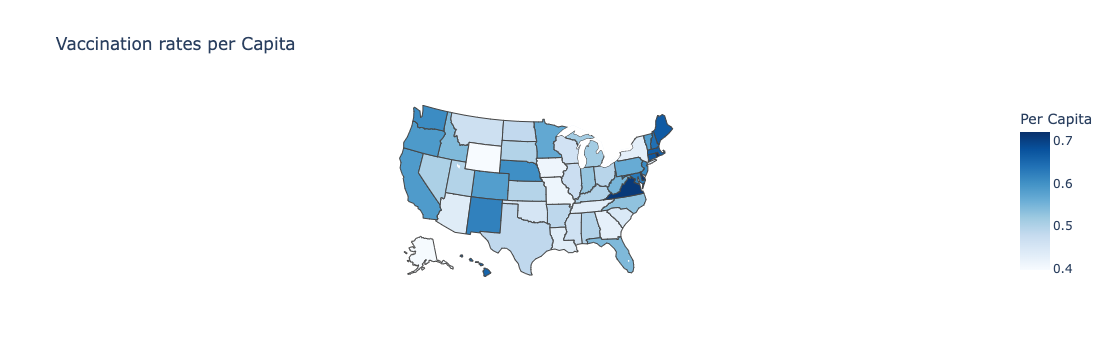

In [412]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
dvdf['code'] = states

fig = go.Figure(data=go.Choropleth(
    locations=dvdf['code'],
    z = dvdf['People_Fully_Vaccinated'], 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "Per Capita",
))

fig.update_layout(
    title_text = 'Vaccination rates per Capita',
    geo_scope='usa', 
)

fig.show()

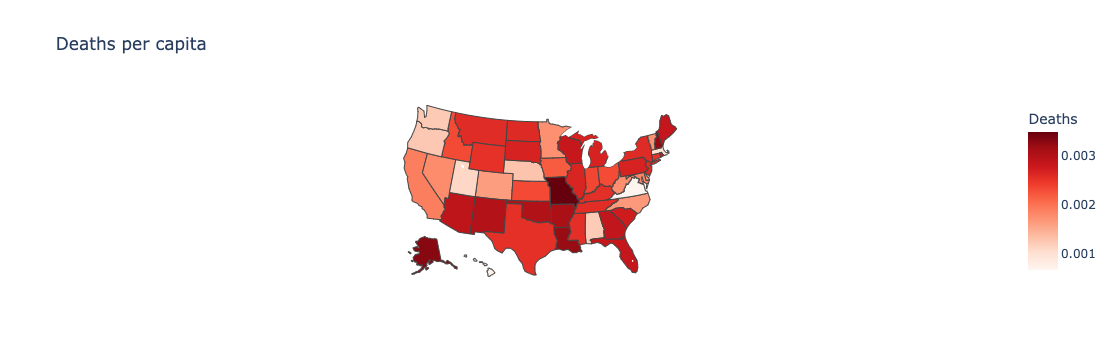

In [ ]:
dpc = deaths.loc[:, ['Province_State', '12/8/21']]
dpc = dpc[dpc['Province_State'].isin(x.index)].set_index('Province_State').groupby('Province_State').agg(sum)

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

dpc['code'] = states
dpc['dpc'] = dpc['12/8/21'] / deaths_vaccinations['POPESTIMATE2020']

fig = go.Figure(data=go.Choropleth(
    locations=dpc['code'],
    z = dpc['dpc'], 
    locationmode = 'USA-states', 
    colorscale = 'Reds',
    colorbar_title = "Deaths",
))

fig.update_layout(
    title_text = 'Deaths per capita',
    geo_scope='usa', 
)

fig.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()